# Running FEISTY with time-series forcing from CESM

Kristen produced a 1 degree companion run to our high-res run on frontera, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper compute node with 50 GB of memory
(the `.compute()` uses a lot of memory on this node, and the `map_da_back_to_2D_pop()` effectively doubles it).
This run actually used all 50 GB, so more might be needed.

## Imports

In [1]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client, wait
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [2]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_g17.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

In [3]:
%%time

print(f'Configuring FEISTY...')

# map_blocks lets us run in parallel over our dask cluster
ds_out = feisty.config_and_run_from_yaml(feisty_config)
ds_out["biomass"]

Configuring FEISTY...
Starting template generation at 13:31:04
CPU times: user 1.7 s, sys: 80.6 ms, total: 1.78 s
Wall time: 2.95 s


<xarray.DataArray 'biomass' (time: 365, group: 9, nlat: 384, nlon: 320)>
dask.array<biomass-config_and_run_from_dataset, shape=(365, 9, 384, 320), dtype=float64, chunksize=(365, 9, 128, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1958-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

## Set up Dask cluster

Since the data in `ds` is chunked in `X`, we use a `dask` cluster to configure the parallelization

In [4]:
mem = 10  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/dev-feisty-new/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44926 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/44926/status,
Dashboard: proxy/44926/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:35457,Workers: 0
Dashboard: proxy/44926/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Run the model

In [5]:
%%time

print(f'Running FEISTY...')
ds_out["biomass"] = ds_out["biomass"].persist()
wait(ds_out["biomass"])
ds_out["biomass"]

Running FEISTY...


/glade/work/mlevy/miniconda3/envs/dev-feisty-new/lib/python3.8/site-packages/distributed/worker.py:2958: UserWarning: Large object of size 1.29 MiB detected in task graph: 
  ([('forcing_time',), <xarray.IndexVariable 'forcin ... time: mean'}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 7.47 s, sys: 668 ms, total: 8.14 s
Wall time: 2min 9s


<xarray.DataArray 'biomass' (time: 365, group: 9, nlat: 384, nlon: 320)>
dask.array<biomass-config_and_run_from_dataset, shape=(365, 9, 384, 320), dtype=float64, chunksize=(365, 9, 128, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1958-01-01 00:00:00 ... 1958-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

### Plotting

Make a plot of `biomass` over time at a specified column

CPU times: user 129 ms, sys: 12.5 ms, total: 141 ms
Wall time: 190 ms


Text(0.5, 0.98, 'biomass at (215, 233)')

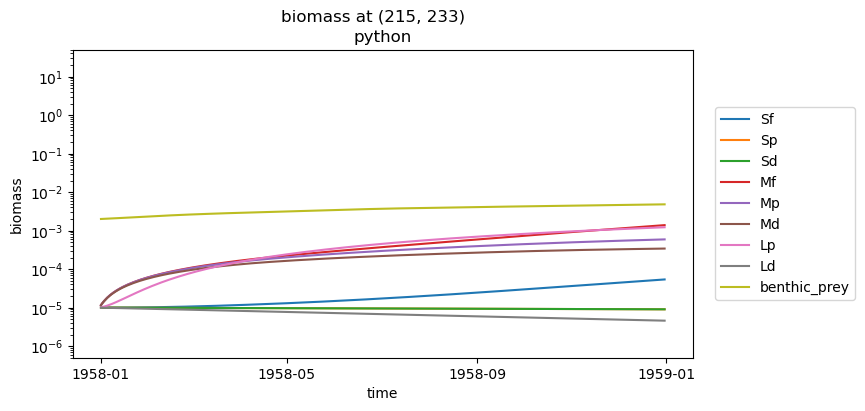

In [6]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-7, 50])
ax.set_yscale("log")
ax.set_title("python")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at ({nlat}, {nlon})");

CPU times: user 63 ms, sys: 4.86 ms, total: 67.8 ms
Wall time: 79 ms


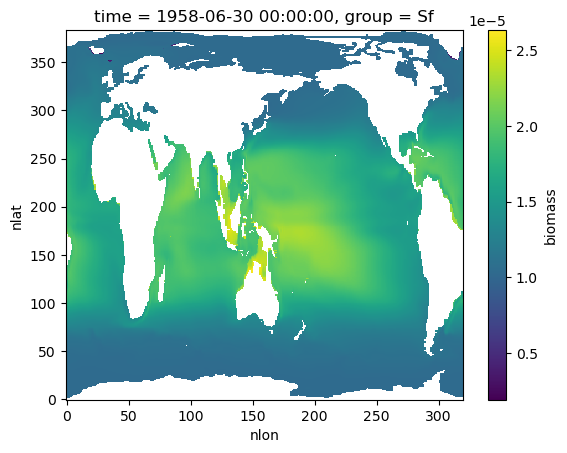

In [7]:
%%time

ds_out["biomass"].isel(time=180, group=0).plot()

In [8]:
%%time

if 'output_file' in feisty_config:
    print(f"Writing to {feisty_config['output_file']}")
    if feisty_config['output_file'][-3:] == '.nc':
        print("Calling to_netcdf...")
        ds_out.to_netcdf(feisty_config['output_file'])
    elif feisty_config['output_file'][-5:] == '.zarr':
        print("Calling to_zarr...")
        ds_out.to_zarr(feisty_config['output_file'])
    else:
        print(f"Can not determine file type for {feisty_config['output_file']}")

CPU times: user 109 ms, sys: 26.1 ms, total: 135 ms
Wall time: 863 ms
